# Some setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from datetime import timedelta
import ast
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

%matplotlib inline  
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8

# Part 1: Read and parse the data

#### Read data as a string

In [2]:
with open('sample.txt', 'r') as myfile:
    data=myfile.read().replace('\n', '')
data[:5000]

'[{  "complemento": {    "valorTotal": 24.9  },  "dets": [    {      "nItem": "1",      "prod": {        "indTot": "1",        "qCom": 1.0,        "uCom": "UN",        "vProd": 3.5,        "vUnCom": 3.5,        "xProd": "AGUA"      }    },    {      "nItem": "2",      "prod": {        "indTot": "1",        "qCom": 0.312,        "uCom": "KG",        "vProd": 21.4,        "vUnCom": 68.6,        "xProd": "BUFFET"      }    }  ],  "emit": {    "cnpj": "01.234.567/0001-89",    "enderEmit": {      "fone": "1-650-933-4902",      "xBairro": "",      "xLgr": "650 Castro St. unit 210",      "xMun": "Mountain View",      "xPais": "United States",      "uf": "CA"    },    "xFant": "TOTVS Labs"  },  "ide": {    "dhEmi": {      "$date": "2016-01-05T12:01:54.000Z"    },    "natOp": "VENDA"  },  "infAdic": {    "infCpl": "Mesa 2"  },  "total": {    "icmsTot": {      "vDesc": 0.0,      "vFrete": 0.0,      "vOutro": 0.0,      "vProd": 24.9,      "vSeg": 0.0,      "vTotTrib": 2.53,      "vbc": 0.0,      

#### It appears that the string defines a list of dictionaries. Convert to list of dictionaries

In [3]:
data = ast.literal_eval(data)
print('number of dictionaries =', len(data))
data[0]

number of dictionaries = 1635


{'complemento': {'valorTotal': 24.9},
 'dets': [{'nItem': '1',
   'prod': {'indTot': '1',
    'qCom': 1.0,
    'uCom': 'UN',
    'vProd': 3.5,
    'vUnCom': 3.5,
    'xProd': 'AGUA'}},
  {'nItem': '2',
   'prod': {'indTot': '1',
    'qCom': 0.312,
    'uCom': 'KG',
    'vProd': 21.4,
    'vUnCom': 68.6,
    'xProd': 'BUFFET'}}],
 'emit': {'cnpj': '01.234.567/0001-89',
  'enderEmit': {'fone': '1-650-933-4902',
   'uf': 'CA',
   'xBairro': '',
   'xLgr': '650 Castro St. unit 210',
   'xMun': 'Mountain View',
   'xPais': 'United States'},
  'xFant': 'TOTVS Labs'},
 'ide': {'dhEmi': {'$date': '2016-01-05T12:01:54.000Z'}, 'natOp': 'VENDA'},
 'infAdic': {'infCpl': 'Mesa 2'},
 'total': {'icmsTot': {'vDesc': 0.0,
   'vFrete': 0.0,
   'vOutro': 0.0,
   'vProd': 24.9,
   'vSeg': 0.0,
   'vTotTrib': 2.53,
   'vbc': 0.0,
   'vbcst': 0.0,
   'vcofins': 0.0,
   'vicms': 0.0,
   'vicmsDeson': 0.0,
   'vii': 0.0,
   'vipi': 0.0,
   'vnf': 24.9,
   'vpis': 0.0,
   'vst': 0.0}},
 'versaoDocumento': 1.0}

#### There are 6 fields in each dictionary: complemento, dets, emit, ide, infAdic and total. Let's write the code to parse each field one-by-one

## complemento

#### Looks like the total of the bill

In [4]:
def parse_complemento(d):
    return pd.Series(d['complemento'])
parse_complemento(data[0])

valorTotal    24.9
dtype: float64

## dets

#### Looks like a list of all the items purchased. First get a unique list of products that people ate/drank

In [5]:
products = []
for d in data:    
    dets = d['dets']    
    for product in dets:        
        product_name = product['prod']['xProd']
        if product_name not in products:            
            products.append(product_name)            
products   

['AGUA',
 'BUFFET',
 'REFRIGERANTE',
 'SUCO',
 'CERVEJA',
 'CHA',
 'DOCINHOS',
 'LIMONADA',
 'HARUMAKI',
 'CAFE EXPRESSO',
 'BULE CHA',
 'TEMAKI',
 'SAKE',
 'CERVEJA LATA',
 'WHISKY',
 'SUSHI ESPECIAL',
 'SASHIMI',
 'CAIPIROSKA',
 'YAKISSOBA',
 'SOBREMESA',
 'CAIPIRINHA',
 'VINHO',
 'BACARDI',
 'URAMAKI']

#### The field qCom appears to be the quantity of the product. For each bill let's get a list of the quantity of each available product

In [6]:
def parse_dets(d):
    s = pd.Series(0, products)
    product_quantities = pd.Series({x['prod']['xProd']: x['prod']['qCom'] for x in d['dets']})
    s[product_quantities.index] = s[product_quantities.index] + product_quantities    
    return s
parse_dets(data[0])

AGUA              1.000
BUFFET            0.312
REFRIGERANTE      0.000
SUCO              0.000
CERVEJA           0.000
CHA               0.000
DOCINHOS          0.000
LIMONADA          0.000
HARUMAKI          0.000
CAFE EXPRESSO     0.000
BULE CHA          0.000
TEMAKI            0.000
SAKE              0.000
CERVEJA LATA      0.000
WHISKY            0.000
SUSHI ESPECIAL    0.000
SASHIMI           0.000
CAIPIROSKA        0.000
YAKISSOBA         0.000
SOBREMESA         0.000
CAIPIRINHA        0.000
VINHO             0.000
BACARDI           0.000
URAMAKI           0.000
dtype: float64

## emit

#### Looks like information about the restaurant. Let's see how many unique restaurants are in the dataset

In [7]:
set([x['emit']['enderEmit']['xLgr'] for x in data])

{'650 Castro St. unit 210'}

#### Only 1, so we can get rid of this field

In [8]:
[x.pop('emit') for x in data]
data[0]

{'complemento': {'valorTotal': 24.9},
 'dets': [{'nItem': '1',
   'prod': {'indTot': '1',
    'qCom': 1.0,
    'uCom': 'UN',
    'vProd': 3.5,
    'vUnCom': 3.5,
    'xProd': 'AGUA'}},
  {'nItem': '2',
   'prod': {'indTot': '1',
    'qCom': 0.312,
    'uCom': 'KG',
    'vProd': 21.4,
    'vUnCom': 68.6,
    'xProd': 'BUFFET'}}],
 'ide': {'dhEmi': {'$date': '2016-01-05T12:01:54.000Z'}, 'natOp': 'VENDA'},
 'infAdic': {'infCpl': 'Mesa 2'},
 'total': {'icmsTot': {'vDesc': 0.0,
   'vFrete': 0.0,
   'vOutro': 0.0,
   'vProd': 24.9,
   'vSeg': 0.0,
   'vTotTrib': 2.53,
   'vbc': 0.0,
   'vbcst': 0.0,
   'vcofins': 0.0,
   'vicms': 0.0,
   'vicmsDeson': 0.0,
   'vii': 0.0,
   'vipi': 0.0,
   'vnf': 24.9,
   'vpis': 0.0,
   'vst': 0.0}},
 'versaoDocumento': 1.0}

## ide

#### Date and time of transaction. Let's see what dates we have

In [9]:
# what dates do we have?
set([x['ide']['dhEmi']['$date'].split('T')[0] for x in data])

{'2016-01-05',
 '2016-01-06',
 '2016-01-07',
 '2016-01-08',
 '2016-01-09',
 '2016-01-11',
 '2016-01-12',
 '2016-01-13',
 '2016-01-14',
 '2016-01-15',
 '2016-01-16',
 '2016-01-18',
 '2016-01-19',
 '2016-01-20',
 '2016-01-21',
 '2016-01-22',
 '2016-01-23'}

#### 3 weeks worth of data. Let's extract the timestamp and also the day and the week

In [10]:
def parse_ide(d):
    time_string = d['ide']['dhEmi']['$date']
    date_and_time = time_string.split('T')
    datetime_str = date_and_time[0] + ' ' + date_and_time[1].split('.')[0]
    date_time = datetime.strptime(datetime_str, '%Y-%m-%d %H:%M:%S')        
    date = datetime.strptime(date_and_time[0], '%Y-%m-%d')
    week = date.isocalendar()[1]
    day = date.weekday()
    return pd.Series([date_time, week, day,], ['datetime', 'week', 'day'])
parse_ide(data[0])

datetime    2016-01-05 12:01:54
week                          1
day                           1
dtype: object

## infAdic

#### Get the table number

In [11]:
def parse_infadic(d):
    return pd.Series(int(d['infAdic']['infCpl'].split()[1]), ['table'])
parse_infadic(data[0])

table    2
dtype: int64

## total

#### Get all fields

In [12]:
def parse_total(d):
    return pd.Series(d['total']['icmsTot'])
parse_total(data[0])

vDesc          0.00
vFrete         0.00
vOutro         0.00
vProd         24.90
vSeg           0.00
vTotTrib       2.53
vbc            0.00
vbcst          0.00
vcofins        0.00
vicms          0.00
vicmsDeson     0.00
vii            0.00
vipi           0.00
vnf           24.90
vpis           0.00
vst            0.00
dtype: float64

#### Now we can combine all the individual parsers to convert the list of dictionaries to a Pandas DataFrame

In [13]:
def dict_to_df(d):    
    df = pd.concat((parse_complemento(d),
              parse_dets(d),
              parse_ide(d),
              parse_infadic(d),
              parse_total(d)))    
    return df        
df = pd.DataFrame([dict_to_df(x) for x in data])  
print('shape =', df.shape)
df.head()

shape = (1635, 45)


,valorTotal,AGUA,BUFFET,REFRIGERANTE,SUCO,CERVEJA,CHA,DOCINHOS,LIMONADA,HARUMAKI,CAFE EXPRESSO,BULE CHA,TEMAKI,SAKE,CERVEJA LATA,WHISKY,SUSHI ESPECIAL,SASHIMI,CAIPIROSKA,YAKISSOBA,SOBREMESA,CAIPIRINHA,VINHO,BACARDI,URAMAKI,datetime,week,day,table,vDesc,vFrete,vOutro,vProd,vSeg,vTotTrib,vbc,vbcst,vcofins,vicms,vicmsDeson,vii,vipi,vnf,vpis,vst
0,24.90,1.0,0.312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016-01-05 12:01:54,1,1,2,0.0,0.0,0.0,24.90,0.0,2.53,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.90,0.0,0.0
1,92.53,0.0,1.218,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016-01-05 12:03:52,1,1,1,0.0,0.0,0.0,92.55,0.0,7.71,0.0,0.0,0.0,0.0,0.0,0.0,0.0,92.55,0.0,0.0
2,57.86,0.0,0.778,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016-01-05 12:16:40,1,1,5,0.0,0.0,0.0,57.87,0.0,2.43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57.87,0.0,0.0
3,34.97,0.0,0.510,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016-01-05 12:17:50,1,1,3,0.0,0.0,0.0,34.98,0.0,1.47,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.98,0.0,0.0
4,46.23,0.0,0.674,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016-01-05 12:18:35,1,1,4,0.0,0.0,0.0,46.23,0.0,1.94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.23,0.0,0.0


# Part 2: Item association rules

#### Let's do some "market basket analysis" to see if we can identify any interesting association rules of the form "item A on bill implies item B on bill". We will compute the following statistics:

* Support is the relative frequency that the rules show up.

* Confidence is a measure of the reliability of the rule. A confidence of .5 in the above example would mean that in 50% of the cases where product A was on the bill, product B was as well.

* Lift is the ratio of the observed support to that expected if the two rules were independent. The basic rule of thumb is that a lift value close to 1 means the rules were completely independent. Lift values > 1 are generally more “interesting” and could be indicative of a useful rule pattern.

In [14]:
products_sets = (df[products] > 0).astype(int)
# generate a frequent items list, show all rules with support at least 5%
frequent_itemsets = apriori(products_sets, min_support=0.05, 
                            use_colnames=True).sort_values('support', 
                                                           ascending=False).reset_index(drop=True)
# compute the support, confidence and lift, showing only rules with lift at least 1
rules = association_rules(frequent_itemsets, 
                          metric="lift", min_threshold=1).sort_values('lift', 
                                                           ascending=False).reset_index(drop=True)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(BUFFET),(REFRIGERANTE),1.000000,0.422630,0.422630,0.422630,1.0,0.0,1.0
1,(REFRIGERANTE),(BUFFET),0.422630,1.000000,0.422630,1.000000,1.0,0.0,inf
2,(BUFFET),(AGUA),1.000000,0.247706,0.247706,0.247706,1.0,0.0,1.0
3,(AGUA),(BUFFET),0.247706,1.000000,0.247706,1.000000,1.0,0.0,inf
4,(BUFFET),(SUCO),1.000000,0.105810,0.105810,0.105810,1.0,0.0,1.0
5,(SUCO),(BUFFET),0.105810,1.000000,0.105810,1.000000,1.0,0.0,inf
6,"(REFRIGERANTE, AGUA)",(BUFFET),0.056881,1.000000,0.056881,1.000000,1.0,0.0,inf
7,(BUFFET),"(REFRIGERANTE, AGUA)",1.000000,0.056881,0.056881,0.056881,1.0,0.0,1.0
8,(BUFFET),(CERVEJA),1.000000,0.055657,0.055657,0.055657,1.0,0.0,1.0
9,(CERVEJA),(BUFFET),0.055657,1.000000,0.055657,1.000000,1.0,0.0,inf


#### Nothing interesting here. Everyone has the buffet and there are no rules with lift greater than 1. Let's move on

# Part 3: Time series analysis

#### Let's analyse the variation in bill total throughout the day, for each day of the week. The individual bill totals are likely to be very noisy, so we'd be better off looking at rolling hourly totals, shifted by a single minute. First we'll need to estimate the opening and closing times of the restaurant

In [15]:
# get the minimum and maximum time for each day
df['time'] = df['datetime'].apply(lambda x: x.time())
min_max_times = df.groupby('day')['time'].agg(['min', 'max']).reset_index(drop=True)
min_max_times

,min,max
0,11:57:51,23:03:32
1,12:01:54,23:40:48
2,12:06:20,23:13:55
3,12:00:42,23:11:07
4,11:58:53,15:24:46
5,11:39:59,15:14:40


#### In order to make it easier to compute the rolling hourly totals, let's use the same opening and closing times for each day, by simpy getting the overall min and max times

In [16]:
opening_time = min_max_times['min'].min()
closing_time = min_max_times['max'].max()

#### Now for each day we compute the running hourly totals, shifted by a single minute, between the opening and closing times

In [17]:
first_day = True
for week in df['week'].unique():
    for day in df['day'].unique():
        # get data for this day only
        df_day = df[(df['week'] == week) & (df['day'] == day)].reset_index(drop=True)
        if len(df_day) > 0:
            # get the timestamps for this particular day
            opening_time_today = datetime.combine(df_day.loc[0, 'datetime'].date(), 
                                                  opening_time)
            closing_time_today = datetime.combine(df_day.loc[0, 'datetime'].date(), 
                                                  closing_time)
            current_time = opening_time_today
            hour_start_times = []
            hourly_totals = []
            while current_time <= (closing_time_today - timedelta(minutes=59)):
                # sum bill totals during this hour
                mask = (df_day['datetime'] >= current_time) & (df_day['datetime'] < current_time 
                                                           + timedelta(minutes=60))
                hourly_totals.append(df_day.loc[mask, 'valorTotal'].sum())
                hour_start_times.append(current_time.time())
                # shift the time window
                current_time += timedelta(minutes=1)
            # add the values to a column in DataFrame
            col_name = 'week' + str(week) + '_day' + str(day)
            if first_day:
                # index is the time the hour starts
                df_rolling_hours = pd.DataFrame(
                    data={col_name: hourly_totals},
                    index=hour_start_times)
                first_day = False
            else:
                df_rolling_hours[col_name] = hourly_totals  
print('shape =', df_rolling_hours.shape)
df_rolling_hours.head()

shape = (662, 17)


,week1_day1,week1_day2,week1_day3,week1_day4,week1_day5,week2_day1,week2_day2,week2_day3,week2_day4,week2_day5,week2_day0,week3_day1,week3_day2,week3_day3,week3_day4,week3_day5,week3_day0
11:39:59,701.60,477.09,633.57,549.74,279.65,378.51,841.91,302.14,453.49,767.66,272.04,495.52,468.51,334.60,1220.78,948.04,314.51
11:40:59,728.25,695.76,633.57,549.74,279.65,378.51,841.91,302.14,583.64,801.41,272.04,495.52,540.73,334.60,1273.19,858.19,354.93
11:41:59,728.25,695.76,633.57,549.74,279.65,378.51,841.91,302.14,660.93,801.41,322.90,495.52,585.94,398.08,1273.19,858.19,354.93
11:42:59,728.25,695.76,633.57,549.74,279.65,378.51,841.91,302.14,790.61,758.61,322.90,495.52,585.94,398.08,1307.36,858.19,354.93
11:43:59,792.83,695.76,633.57,549.74,369.82,378.51,841.91,302.14,790.61,784.23,322.90,495.52,618.23,398.08,1342.21,858.19,389.22


#### Let's visualise the running hourly totals throughout each day during each week

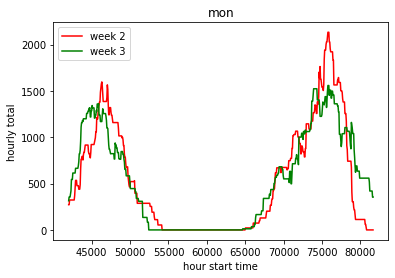

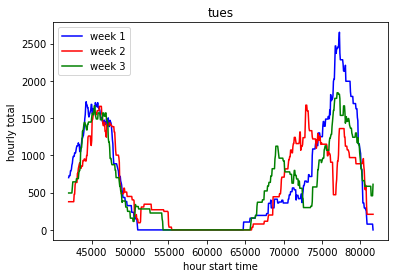

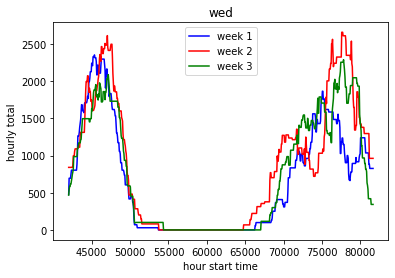

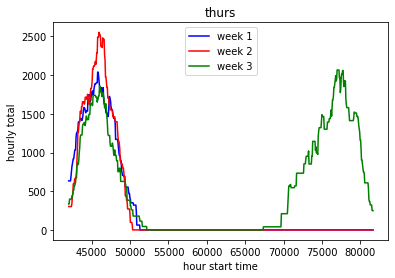

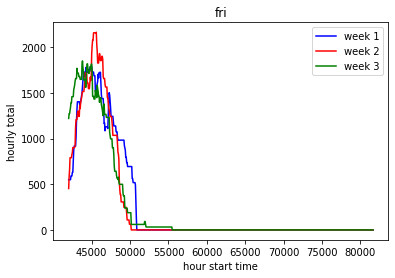

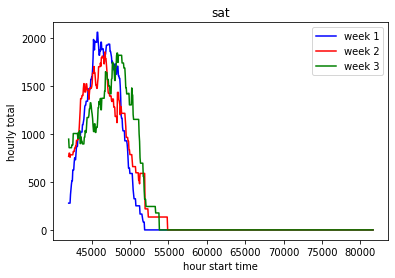

In [18]:
days = ['mon', 'tues', 'wed', 'thurs', 'fri', 'sat']
colours = ['blue', 'red', 'green']

X_time_axis = []
for i in range(662):
  X_time_axis.append(df_rolling_hours.index[i].hour * 3600 + df_rolling_hours.index[i].minute * 60 + df_rolling_hours.index[i].second )

for day in np.arange(6):
    for week in np.arange(1,4):   
        col_name = 'week' + str(week) + '_day' + str(day)
        if col_name in df_rolling_hours.columns.tolist():
            plt.plot(X_time_axis, 
                     df_rolling_hours[col_name], 
                     color=colours[week-1], 
                     label= 'week ' + str(week))
    plt.title(days[day])
    plt.xlabel('hour start time')
    plt.ylabel('hourly total')
    plt.legend()
    plt.show()

## Observations:

1. No data for Monday of week 1
2. Monday to Wednesday the restaurant appears to close after lunch and re-opens in the early evening
3. On Thursday of weeks 1 and 2 the restaurant appears not to re-open after lunch, but during week 3 it did open again in the evening
4. The restaurant does not re-open after lunc on Fridays and Saturdays
5. The restaurant does not open at all on Sundays
6. Otherwise, the running totals for each day seem to follow similar patters each week

#### To complete the weeks let's add a column of zeros for each Sunday

In [19]:
df_rolling_hours['week1_day6'] = 0
df_rolling_hours['week2_day6'] = 0
df_rolling_hours['week3_day6'] = 0
# put the columns in the same order as the days
df_rolling_hours = df_rolling_hours[sorted(df_rolling_hours.columns.tolist())]
df_rolling_hours.head()

,week1_day1,week1_day2,week1_day3,week1_day4,week1_day5,week1_day6,week2_day0,week2_day1,week2_day2,week2_day3,week2_day4,week2_day5,week2_day6,week3_day0,week3_day1,week3_day2,week3_day3,week3_day4,week3_day5,week3_day6
11:39:59,701.60,477.09,633.57,549.74,279.65,0,272.04,378.51,841.91,302.14,453.49,767.66,0,314.51,495.52,468.51,334.60,1220.78,948.04,0
11:40:59,728.25,695.76,633.57,549.74,279.65,0,272.04,378.51,841.91,302.14,583.64,801.41,0,354.93,495.52,540.73,334.60,1273.19,858.19,0
11:41:59,728.25,695.76,633.57,549.74,279.65,0,322.90,378.51,841.91,302.14,660.93,801.41,0,354.93,495.52,585.94,398.08,1273.19,858.19,0
11:42:59,728.25,695.76,633.57,549.74,279.65,0,322.90,378.51,841.91,302.14,790.61,758.61,0,354.93,495.52,585.94,398.08,1307.36,858.19,0
11:43:59,792.83,695.76,633.57,549.74,369.82,0,322.90,378.51,841.91,302.14,790.61,784.23,0,389.22,495.52,618.23,398.08,1342.21,858.19,0


# Part 4: LSTM neural network sales forecasting model

#### Long short-term memory (LSTM) neural networks are excellent at modelling time series data. Let's see if we can use an LSTM to build a reliable sales forecast model.

#### We first have to construct a training set. For any given hour, let's use the hourly totals during that hour over a period of 7 days as features and the total during the same hour on the next day as the target. This idea is illustrated below:

#### [tues, wed, thurs, fri, sat, sun, mon] --> [tues]
#### [wed, thurs, fri, sat, sun, mon, tues] --> [wed]
#### [thurs, fri, sat, sun, mon, tues, wed] --> [thurs]
#### ........

#### Note that we will not use any hours during Sundays as targets as they are all 0

#### This will generate (number of rolling hours) x (number of days not Sunday -  6) training examples

In [20]:
num_days_train = 7
df_sequences = pd.DataFrame(columns=['day(t' + str(x) + ')' for x in np.arange(-7, 0)] + ['day(t)'])
cols = df_rolling_hours.columns.tolist()
for i in np.arange(0, df_rolling_hours.shape[1] - num_days_train):
    target_col = cols[i + num_days_train]
    # don't want sundays as target
    if not target_col.endswith('6'):
        print('target =', target_col)
        sequence_cols = cols[i:i + num_days_train + 1]
        df_temp = pd.DataFrame(data=df_rolling_hours[sequence_cols].values,
                              columns=df_sequences.columns.tolist())
        df_sequences = df_sequences.append(df_temp, ignore_index=True)          
print('shape =', df_sequences.shape)
df_sequences.head()

target = week2_day1
target = week2_day2
target = week2_day3
target = week2_day4
target = week2_day5
target = week3_day0
target = week3_day1
target = week3_day2
target = week3_day3
target = week3_day4
target = week3_day5
shape = (7282, 8)


,day(t-7),day(t-6),day(t-5),day(t-4),day(t-3),day(t-2),day(t-1),day(t)
0,701.60,477.09,633.57,549.74,279.65,0.0,272.04,378.51
1,728.25,695.76,633.57,549.74,279.65,0.0,272.04,378.51
2,728.25,695.76,633.57,549.74,279.65,0.0,322.90,378.51
3,728.25,695.76,633.57,549.74,279.65,0.0,322.90,378.51
4,792.83,695.76,633.57,549.74,369.82,0.0,322.90,378.51


#### We have a total of 7282 training examples across 11 target days. Let's use the first 5 days for training, the next 3 for validation and the last 3 for testing our final model.

#### This is not ideal as the target days in the test set (Thursday - Saturday in week 3) are quite different from the other days, but we don't have much of a choice as it would not be fair to train in the future and test in the past.

In [21]:
# we can use the length of df_rolling_hours to get the lines we want
df_train = df_sequences[:int(df_rolling_hours.shape[0] * 5)]
df_val = df_sequences[int(df_rolling_hours.shape[0] * 5):int(df_rolling_hours.shape[0] * 8)]
df_test = df_sequences[int(df_rolling_hours.shape[0] * 8):]
print('train shape:', df_train.shape)
print('val shape:', df_val.shape)
print('test shape:', df_test.shape)

train shape: (3310, 8)
val shape: (1986, 8)
test shape: (1986, 8)


#### It's always better to normalise the data before training a neural network. Let's use MinMaxScaler to do this. Note that we must fit the scaler to the training data ONLY, and apply the same transformations to the validation and test sets

In [22]:
# fit to training data
scaler = MinMaxScaler()
scaler.fit(df_train)
# transform all data
df_train = scaler.transform(df_train)
df_val = scaler.transform(df_val)
df_test = scaler.transform(df_test)

#### Separate data into X and y. Also, the LSTM layer from the Keras library expects the features in a 3D format of the form [samples, timesteps, features]. Seeing as each sample only has one set of features (the hourly totals), we simply add a third dimension with size 1

In [23]:
X_train = df_train[:, :-1]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
y_train = df_train[:, -1]
X_val = df_val[:, :-1]
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
y_val = df_val[:, -1]
X_test = df_test[:, :-1]
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
y_test = df_test[:, -1]

## Baseline Model

#### Before we train the neural network let's create a baseline model and then try to beat it. A good baseline is simply predicting the same sales as the same day of the previous week.

#### Recall that the sales for the same day of the previous week are in the first column of the feature set

In [24]:
print('Baseline Validation MSE =', mean_squared_error(y_val, X_val[:, 0]))

Baseline Validation MSE = 0.01428338797298752


#### Now we will train and validate a number of LSTMs with a single LSTM layer followed by a fully-connected affine layer with a single output. We will use dropout in the linear transformation of the LSTM layer to control overfitting, and the Adam optimiser to minimise mean squared error (MSE). We will train for a maximum of 200 epochs, but we will monitor the validation loss after every epoch and stop training early if the loss stops decreasing (patience=10)


#### We will perform grid search on the number of cells in the LSTM layer, the dropout rate and the learning rate of the Adam optimiser.

In [25]:
results = {}
for num_cells in [10, 20, 30, 40, 50]:
    for dropout_rate in [0, 0.1, 0.2]:
        for lr in [1e-4, 3e-4, 1e-3, 3e-3, 1e-2]:

            print('Running with', num_cells, 
                  'LSTM cells, dropout =', dropout_rate, 
                  'and learning rate =', lr, '...')

            # build network
            model = Sequential()
            model.add(LSTM(num_cells, input_shape=(X_train.shape[1], X_train.shape[2]), 
                           dropout=dropout_rate))
            model.add(Dense(1))
            optimiser = Adam(lr=lr)
            model.compile(loss='mse', optimizer=optimiser)

            # fit network for a maximum of 200 epochs with early stopping (patience=10)
            early_stopping = EarlyStopping(monitor='val_loss', patience=10)
            history = model.fit(X_train, y_train, epochs=200, batch_size=128, 
                                validation_data=(X_val, y_val), callbacks=[early_stopping],
                                verbose=0, shuffle=True)

            # get training and validation loss at best epoch (number of epochs - patience)
            num_epochs = len(history.history['val_loss'])
            best_epoch = num_epochs - 10
            train_mse = history.history['loss'][best_epoch]
            val_mse = history.history['val_loss'][best_epoch] 
            results[(num_cells, dropout_rate, lr, best_epoch)] = {'train_mse': train_mse, 
                                                                  'val_mse': val_mse}                                                                                          
            print('Train MSE =', train_mse, ', Validation MSE =', val_mse)        
            print('+----------------------------------------------------------------------+')

Running with 10 LSTM cells, dropout = 0 and learning rate = 0.0001 ...
Train MSE = 0.029872626066207886 , Validation MSE = 0.025961000472307205
+----------------------------------------------------------------------+
Running with 10 LSTM cells, dropout = 0 and learning rate = 0.0003 ...
Train MSE = 0.011529490351676941 , Validation MSE = 0.010426370427012444
+----------------------------------------------------------------------+
Running with 10 LSTM cells, dropout = 0 and learning rate = 0.001 ...
Train MSE = 0.011847475543618202 , Validation MSE = 0.011180350556969643
+----------------------------------------------------------------------+
Running with 10 LSTM cells, dropout = 0 and learning rate = 0.003 ...
Train MSE = 0.01321148220449686 , Validation MSE = 0.012923021800816059
+----------------------------------------------------------------------+
Running with 10 LSTM cells, dropout = 0 and learning rate = 0.01 ...
Train MSE = 0.009063576348125935 , Validation MSE = 0.012240478768

#### Get the parameters of the model with the lowest validation loss and train it 

In [26]:
val_results = {key: results[key]['val_mse'] for key in results.keys()}
num_cells, dropout_rate, lr, num_epochs = min(val_results, key=val_results.get)
print('Best parameters:', num_cells, 
        'LSTM cells, training for', num_epochs, 
        'epochs with dropout =', dropout_rate, 
        'and learning rate =', lr)

Best parameters: 50 LSTM cells, training for 80 epochs with dropout = 0.1 and learning rate = 0.0001


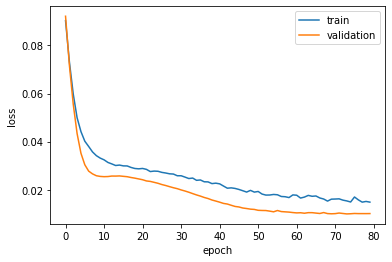

Final Validation MSE = 0.010051720775663853


In [27]:
# build network
model = Sequential()
model.add(LSTM(num_cells, input_shape=(X_train.shape[1], X_train.shape[2]), 
               dropout=dropout_rate))
model.add(Dense(1))
optimiser = Adam(lr=lr)
model.compile(loss='mse', optimizer=optimiser)

# fit network
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=128, 
                    validation_data=(X_val, y_val),
                    verbose=0, shuffle=True)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()
val_mse = history.history['val_loss'][-1]
print('Final Validation MSE =', val_mse)

### We beat the baseline by 0.00426 MSE!

#### Now let's visualise the predictions compared with the actual values. We will have to unscale the values first

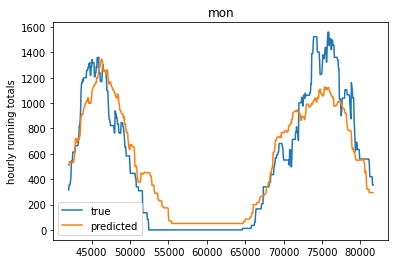

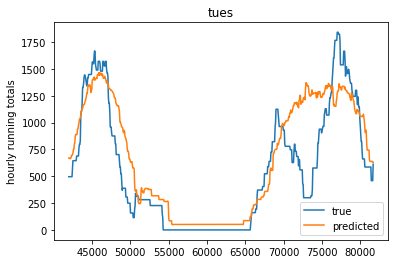

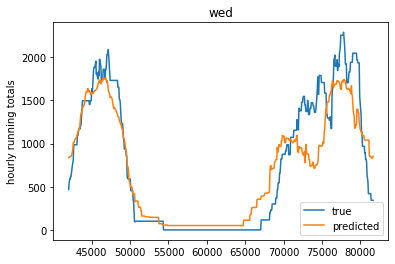

In [28]:
# get validation predictions
y_val_pred = model.predict(X_val)

# undo the scaling of the target variable
def unscale_y(y):    
    return scaler.inverse_transform(np.hstack((np.ones((y.shape[0], X_train.shape[1])), 
                                                      y.reshape((y.shape[0], 1)))))[:, -1]
y_val_unscaled = unscale_y(y_val)
y_val_pred_unscaled = unscale_y(y_val_pred)

# plot validation predictions vs true values for each target day
X_time_axis = []
for i in range(662):
  X_time_axis.append(df_rolling_hours.index[i].hour * 3600 + df_rolling_hours.index[i].minute * 60 + df_rolling_hours.index[i].second )

for i, day in enumerate(['mon', 'tues', 'wed']):
    i_first = i * len(X_time_axis)
    i_last = (i + 1) * len(X_time_axis)    
    plt.plot(X_time_axis, y_val_unscaled[i_first:i_last], label='true')
    plt.plot(X_time_axis, y_val_pred_unscaled[i_first:i_last], label='predicted')
    plt.title(day)
    plt.ylabel('hourly running totals')
    plt.legend()
    plt.show()

#### The model does reasonably well at predicting the true time series. However, it wasn't able to predict that there would be a drop in sales between roughly 19:30 and 21:00 on the Tuesday, then predicted that there would be a drop on the Wednesday during the same time period, which didn't actually happen. It therefore appears that the model is being heavily influenced by what happened on the previous day. Also, during the hours that the restaurant is closed it doesn't predict exactly zero sales.

#### Let's train our chosen model on the training and validation data and evaluate on the test set to get a fairer estimate of the error.

In [29]:
# build network
model = Sequential()
model.add(LSTM(num_cells, input_shape=(X_train.shape[1], X_train.shape[2]), 
               dropout=dropout_rate))
model.add(Dense(1))
optimiser = Adam(lr=lr)
model.compile(loss='mse', optimizer=optimiser)

# fit network
history = model.fit(np.vstack((X_train, X_val)), 
                    np.concatenate((y_train, y_val)), 
                    epochs=num_epochs, batch_size=128, 
                    validation_data=(X_test, y_test),
                    verbose=0, shuffle=True)

test_mse = history.history['val_loss'][-1]
print('Final Test MSE =', test_mse)

Final Test MSE = 0.021497229114174843


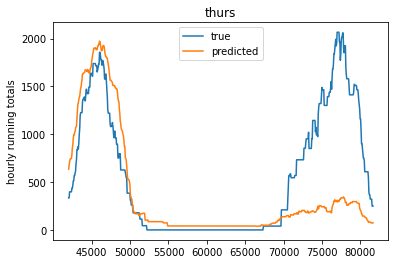

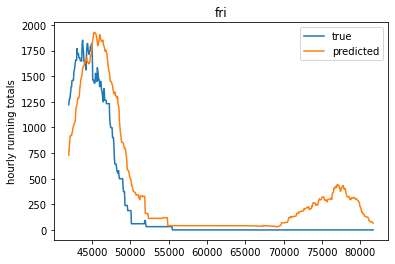

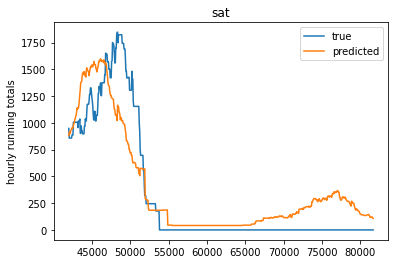

In [30]:
# get test predictions and unscale
y_test_pred = model.predict(X_test)
y_test_unscaled = unscale_y(y_test)
y_test_pred_unscaled = unscale_y(y_test_pred)

# plot test predictions vs true values for each target day
for i, day in enumerate(['thurs', 'fri', 'sat']):
    i_first = i * len(X_time_axis)
    i_last = (i + 1) * len(X_time_axis)    
    plt.plot(X_time_axis, y_test_unscaled[i_first:i_last], label='true')
    plt.plot(X_time_axis, y_test_pred_unscaled[i_first:i_last], label='predicted')
    plt.title(day)
    plt.ylabel('hourly running totals')
    plt.legend()
    plt.show()

#### Unsurprisingly the model was unable to predict that the restaurant would open on Thursday afternoon, resulting in quite a high MSE relative to the validation error. However, it's actually good to see that the model learned from the fact that during the first 2 weeks the restaurant didn't open on Thursday afternoon and didn't just copy what happened on the Wednesday. The model correctly learned that the restaurant would not open in the afternoon on Friday and Saturday, although it wasn't able to predict exactly zero sales during these times and actually predicted slightly negative values for some hours.

#### Overall, considering the limited training data available and the significant differences between training and test data, I think the model is pretty respectable. If several more weeks of data were available I believe it would perform very well.  

#### Let's train the model with all the data and make a sales forecast for week 4.

In [31]:
# build network
model = Sequential()
model.add(LSTM(num_cells, input_shape=(X_train.shape[1], X_train.shape[2]), 
               dropout=dropout_rate))
model.add(Dense(1))
optimiser = Adam(lr=lr)
model.compile(loss='mse', optimizer=optimiser)

# fit network
model.fit(np.vstack((X_train, X_val, X_test)), 
                    np.concatenate((y_train, y_val, y_test)), 
                    epochs=num_epochs, batch_size=128, 
                    verbose=0, shuffle=True)

#### We will make a sales forecast as follows:

1. apply model to final 7 days of training data to predict sales on the monday of the 4th week
2. apply model to final 6 days of training data + predicted sales on monday of the 4th week to predict sales on the tuesday of 4th week
3. apply model to final 5 days of training data + predicted sales on monday & tuesday of the 4th week to predict sales on the wednesday of 4th week
4. and so on...


#### Also, let's force the predictions to be zero during the hours we believe the restaurant to be closed. Consider the restaurant to be closed during a certain hour on a certain day if the sales are zero during the same hour on the same day in all weeks of the training data.

In [32]:
# create a dataframe for storing predictions
week_days = {0: 'mon', 1: 'tues', 2: 'wed', 3: 'thurs', 4: 'fri', 5: 'sat'}
df_forecast = pd.DataFrame(index=df_rolling_hours.index, columns=week_days.values())

# get columns of final 7 days in training data
feature_cols = [x for x in df_rolling_hours.columns if x.startswith('week3')]
X_current = df_rolling_hours[feature_cols]

# normalise and reshape
X_current = scaler.transform(np.hstack((X_current, np.ones((X_current.shape[0], 1)))))[:, :-1]
X_current = X_current.reshape((X_current.shape[0], X_current.shape[1], 1))

for day_idx, day in week_days.items():
    
    # predict
    y_pred = model.predict(X_current)
    y_pred_unscaled = unscale_y(y_pred) 
    
    # closed?
    day_cols = [x for x in df_rolling_hours.columns if x.endswith(str(day_idx))]
    closed_mask = (df_rolling_hours[day_cols] == 0).all(axis=1).values
    y_pred_unscaled[closed_mask] = 0    
    df_forecast[day] = y_pred_unscaled
    
    # shift X by a day
    X_current = X_current.reshape((X_current.shape[0], X_current.shape[1]))
    X_current = np.hstack((X_current[:, 1:], 
                           y_pred.reshape((y_pred.shape[0], 1))))
    X_current = X_current.reshape((X_current.shape[0], X_current.shape[1], 1))
    
df_forecast.head()

,mon,tues,wed,thurs,fri,sat
11:39:59,501.665915,653.878780,721.867078,827.772359,1159.887769,987.174224
11:40:59,523.193265,672.816337,776.432680,849.047462,1179.783007,942.461798
11:41:59,522.224878,683.195893,817.023116,894.499739,1192.529688,947.957547
11:42:59,522.292440,682.295384,816.853656,899.228359,1205.961424,951.131926
11:43:59,544.683346,693.025041,839.670789,909.825429,1221.889225,954.819522


#### Visualise the results compared with the 3 observed weeks

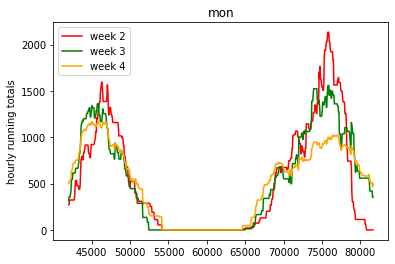

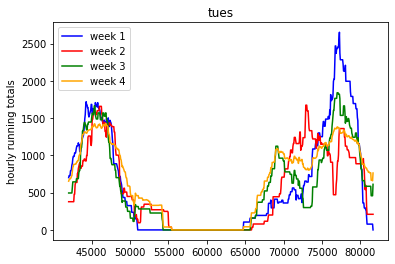

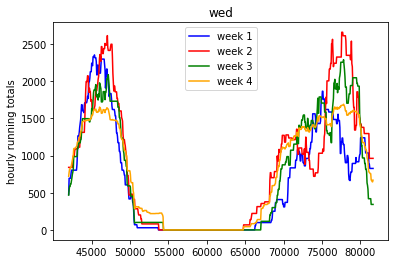

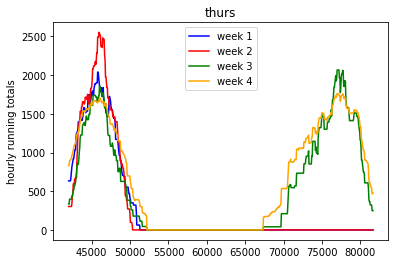

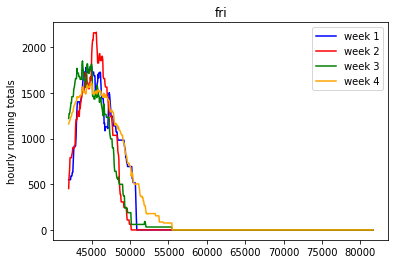

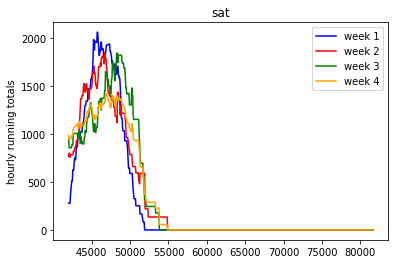

In [33]:
days = ['mon', 'tues', 'wed', 'thurs', 'fri', 'sat']
colours = ['blue', 'red', 'green']

X_time_axis = []
for i in range(662):
  X_time_axis.append(df_rolling_hours.index[i].hour * 3600 + df_rolling_hours.index[i].minute * 60 + df_rolling_hours.index[i].second )

for day in np.arange(6):
    # plot 3 observed weeks
    for week in np.arange(1,4):   
        col_name = 'week' + str(week) + '_day' + str(day)
        if col_name in df_rolling_hours.columns.tolist():
            plt.plot(X_time_axis, df_rolling_hours[col_name], 
                    color=colours[week-1], label= 'week ' + str(week))
    # plot 4th week sales forecast
    plt.plot(X_time_axis, df_forecast[days[day]], 
                    color='orange', label='week 4')    
    plt.title(days[day])
    plt.ylabel('hourly running totals')
    plt.legend()
    plt.show()

#### The series which the model predicts for week 4 are similar to those of the first 3 weeks. It seems to have learned the general trend. Let's finish by calculating total sales per day.

#### Note that the first time in the dataset is 11:39:59 and the last time is 22:40:59. We will calculate a total sales forecast using an averaging technique as follows:

1. sum the hourly totals with the following start times: 11:39:59, 12:39:59, 13:39:59, ..., 22:39:59
2. sum the hourly totals with the following start times: 11:40:59, 12:40:59, 13:40:59, ..., 22:40:59
3. sum the hourly totals with the following start times: 11:41:59, 12:41:59, 13:41:59, ..., 22:40:59
4. and so on until we reach 11:48:59 as our starting point...then average the results of the 10 separate estimates

Week 4 sales forecast for mon is 5969.0


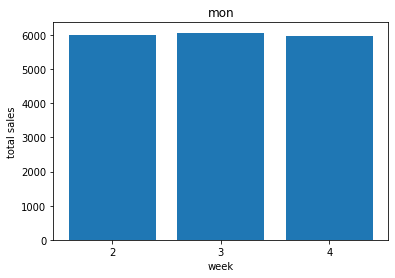

Week 4 sales forecast for tues is 7785.0


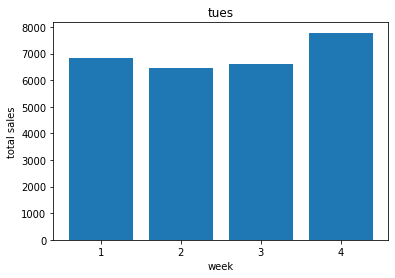

Week 4 sales forecast for wed is 8935.0


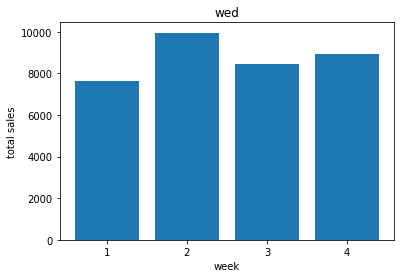

Week 4 sales forecast for thurs is 7920.0


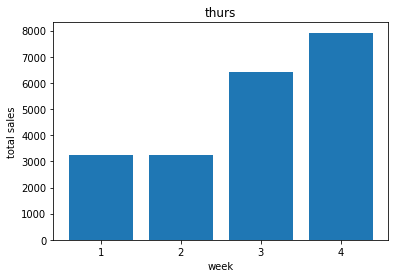

Week 4 sales forecast for fri is 3755.0


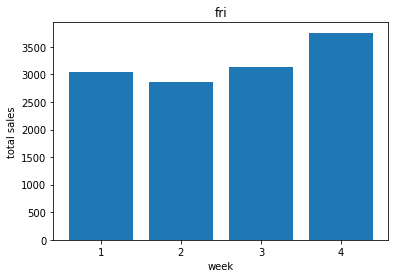

Week 4 sales forecast for sat is 3694.0


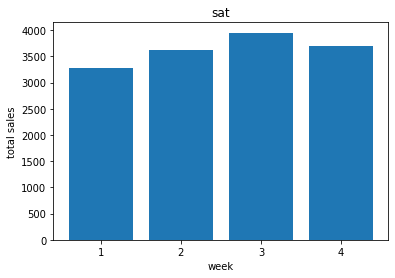

Total sales forecast for week 4 is 38059.0


In [34]:
# compute observed daily totals
observed_totals = df.groupby(['week', 'day'])['valorTotal'].sum().reset_index()

# estimate daily totals in 4th week
daily_totals = {}
for day_idx, day in week_days.items():
    estimates = []
    for i in np.arange(10):
        start_times = [(datetime.combine(datetime.today().date(), 
                          df_forecast.index[i]) + j * timedelta(minutes=60)
                       ).time() for j in np.arange(12)]
        if start_times[-1] > df_forecast.index[-1]:
            start_times[-1] = df_forecast.index[-1]
        estimates.append(df_forecast.loc[start_times, day].sum())
    daily_totals[day] = sum(estimates) / len(estimates)
    print('Week 4 sales forecast for', day, 'is', np.round(daily_totals[day]))
    
    # plot trend
    totals = observed_totals.loc[observed_totals['day'] == day_idx, 'valorTotal'].values.tolist()
    totals.append(daily_totals[day])
    if day == 'mon':
        plt.bar([2, 3, 4], totals)
        plt.gca().set_xticks([2, 3, 4])
    else:
        plt.bar([1, 2, 3, 4], totals)
        plt.gca().set_xticks([1, 2, 3, 4])
    plt.title(day)
    plt.xlabel('week')
    plt.ylabel('total sales')
    plt.show() 
    
# total sales 
print('Total sales forecast for week 4 is', np.round(sum(list(daily_totals.values()))))

# That's all folks!